In [1]:
import sys
import os
sys.path.append(os.getcwd()[:-8])

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [4]:
from ACME.ACME import ACME
import numpy as np
import pandas as pd

In [5]:
mean = [5,5,5,5,5,5]
cov = np.identity(6)
x_normal = pd.DataFrame(np.random.multivariate_normal(mean, cov, 5000), columns = ['f'+str(i) for i in range(1,7)] )
x_normal['is_out'] = 0

In [6]:
mean = [5,3,5,5,10,0]
cov = np.identity(6)
x_outliers = pd.DataFrame(np.random.multivariate_normal(mean, cov, 200), columns = ['f'+str(i) for i in range(1,7)] )
x_outliers['is_out'] = 1

In [7]:
X = pd.concat([x_normal,x_outliers],ignore_index=True, sort=False).reset_index(drop=True)

In [8]:
X.head(3)

,f1,f2,f3,f4,f5,f6,is_out
0,5.451259,4.763743,5.433215,3.627454,8.460058,6.194635,0
1,4.215127,6.029022,5.229701,5.768882,6.551292,5.400953,0
2,6.149577,4.090795,3.661920,6.184722,4.478790,5.343349,0


In [9]:
features = ['f'+str(i) for i in range(1,7)]

In [10]:
from sklearn.ensemble import IsolationForest
if_model = IsolationForest(random_state=0).fit(X[features])

In [11]:
X['pred_AD_score'] = if_model.decision_function(X[features])
X.tail()

,f1,f2,f3,f4,f5,f6,is_out,pred_AD_score
5195,5.246719,2.335135,6.680622,6.445316,11.252835,-0.823410,1,0.158615
5196,2.591363,3.634174,4.035704,6.727754,9.176601,1.729152,1,0.125389
5197,3.731431,0.586555,3.864337,4.787120,9.451596,-0.584835,1,0.136085
5198,6.240268,3.713027,5.070517,4.085483,9.618007,-1.099903,1,0.119100
5199,5.103153,5.474457,4.896490,5.301103,10.680816,1.006071,1,0.060271


<AxesSubplot:ylabel='Frequency'>

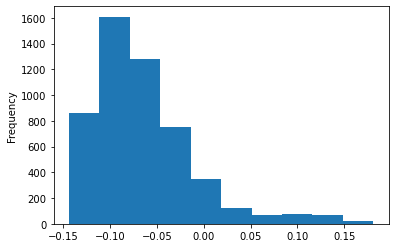

In [12]:
X['pred_AD_score'].plot(kind='hist')

In [13]:
X.loc[(-0.01<X['pred_AD_score']) & (X['pred_AD_score']<0)].sort_values(by='pred_AD_score', ascending=True).head(10)

,f1,f2,f3,f4,f5,f6,is_out,pred_AD_score
4625,7.505392,5.290536,7.200113,5.036404,5.711419,5.506047,0,-0.009584
3845,3.586814,3.399716,6.736997,3.436930,4.734071,6.323964,0,-0.009240
3174,4.886822,7.723372,5.362516,3.616223,4.275236,4.484905,0,-0.009238
3851,4.572504,4.509557,2.396950,6.091499,4.443675,6.393909,0,-0.009157
3030,5.364940,6.420384,4.945175,8.492813,3.398721,5.818602,0,-0.009047
2640,7.486103,5.746101,4.579300,6.222311,6.689354,6.049775,0,-0.008999
1010,3.608457,4.544999,7.820532,4.039317,5.691060,3.454153,0,-0.008897
3707,2.901075,6.149805,3.596474,5.987495,6.279421,4.087001,0,-0.008783
3153,7.023113,6.799617,4.401602,4.955285,6.186143,6.111459,0,-0.008771
3795,5.441406,7.403870,5.591726,4.133044,3.432385,5.402305,0,-0.008651


In [88]:
k = 30
def score_function(model, data):
    try: # for global
        df = model.decision_function(data)
    except: # for local
        df = model.decision_function(data.reshape(1,-1))
    
    return -1*df

acme_ifo = ACME(if_model, 'AD_score', K=k, task='regression', score_function=score_function, features=features)
acme_ifo = acme_ifo.fit(X[features], robust = True)

In [89]:
#acme_local = acme_ifo.fit_local(X, 5100)
acme_local = acme_ifo.fit_local(X[features], 4277)

In [90]:
local_table = acme_local.local_table()

In [91]:
local_table.shape #(n_rows = n_features x quantiles)

(180, 7)

In [92]:
local_table

,effect,predictions,mean_prediction,original,quantile,Importance,local_quantile
f2,0.028010,0.028010,-0.046369,-0.690634,0.000000,0.030630,0.275862
f2,0.010201,0.010201,-0.046369,2.855548,0.034483,0.030630,0.275862
f2,-0.008760,-0.008760,-0.046369,3.318358,0.068966,0.030630,0.275862
f2,-0.026490,-0.026490,-0.046369,3.581936,0.103448,0.030630,0.275862
f2,-0.034664,-0.034664,-0.046369,3.787819,0.137931,0.030630,0.275862
...,...,...,...,...,...,...,...
f5,-0.038184,-0.038184,-0.046369,6.268078,0.862069,0.017292,0.206897
f5,-0.032163,-0.032163,-0.046369,6.486370,0.896552,0.017292,0.206897
f5,-0.024984,-0.024984,-0.046369,6.849848,0.931034,0.017292,0.206897
f5,0.042707,0.042707,-0.046369,8.732333,0.965517,0.017292,0.206897


In [93]:
change_anomalies = {}
no_change_anomalies = {}
importance_change = {}

for feature in local_table.index.unique():
    min_pred = local_table.loc[feature,'predictions'].min()
    max_pred = local_table.loc[feature,'predictions'].max()
    if np.sign(min_pred) !=  np.sign(max_pred):
        change_anomalies[feature] = [min_pred,max_pred]
        #importance_change[feature] = np.abs(np.abs(min_pred)-np.abs(max_pred)) #why not just max - min (by default, min is negative)?
        importance_change[feature] = max_pred - min_pred #why not just max - min (by default, min is negative)?
    else:
        importance_change[feature] = 0
        no_change_anomalies[feature] = [min_pred, max_pred]
        
#we could also define importance more generally as max - min (also for features without sign change)
#is there a notion of margin we can take into account to assess who normal/abnormal a sample is? 
#   (e.g. this observation can never be normal if we change a value at a time)

In [94]:
change_anomalies

{'f2': [-0.05834568069296164, 0.05980742777852188],
 'f3': [-0.07250365517282575, 0.035117488789374374],
 'f6': [-0.05515728496481398, 0.06620982149319232],
 'f4': [-0.07522849951800653, 0.013467516602212126],
 'f1': [-0.07191499558621589, 0.028875928268084383],
 'f5': [-0.052706993749914, 0.07072014619123956]}

In [95]:
no_change_anomalies

{}

In [96]:
importance_change

{'f2': 0.11815310847148353,
 'f3': 0.10762114396220013,
 'f6': 0.1213671064580063,
 'f4': 0.08869601612021866,
 'f1': 0.10079092385430027,
 'f5': 0.12342713994115356}

In [97]:
pd.concat([pd.DataFrame(importance_change,index=['AD importance score']).T,pd.DataFrame(change_anomalies,index=['Min','Max']).T],axis=1).sort_values('AD importance score',ascending=False)

,AD importance score,Min,Max
f5,0.123427,-0.052707,0.070720
f6,0.121367,-0.055157,0.066210
f2,0.118153,-0.058346,0.059807
f3,0.107621,-0.072504,0.035117
f1,0.100791,-0.071915,0.028876
f4,0.088696,-0.075228,0.013468


In [113]:
feature = 'f6'
imp_table = local_table.loc[feature]

In [114]:
imp_table['direction'] = 'normal'
imp_table.loc[imp_table.predictions<0,'direction'] = 'anomalies'
imp_table['effect'] = np.abs(imp_table['predictions'] - imp_table['mean_prediction'] )*np.sign(imp_table['predictions'])

In [116]:
import plotly.graph_objects as go

actual_score = imp_table['mean_prediction'].values[0]
actual_values = imp_table.loc[imp_table['quantile'] == imp_table['local_quantile'].values[0], 'original'].values[0]
color = 'red' if actual_score > 0 else 'blue'

fig = go.Figure()
fig.add_bar(x = imp_table.loc[imp_table.direction=='anomalies','effect'], y = imp_table.loc[imp_table.direction=='anomalies','original'].values, base =  imp_table['mean_prediction'].values[0], marker=dict(color = 'blue'), name = 'Anomalies',orientation='h', )

fig.add_bar(x = imp_table.loc[imp_table.direction=='normal','effect'], y = imp_table.loc[imp_table.direction=='normal','original'].values, base =  imp_table['mean_prediction'].values[0], marker=dict(color = 'red'), name = 'Normal', orientation='h',)

fig.add_scatter( y = [ imp_table['original'].values[0]*0.9 ,imp_table['original'].values[-1]*1.05 ],
                 x = [ actual_score,actual_score ], mode='lines',
                name = 'actual score', line=dict(color = color ,width=2,dash="dash") )

fig.add_scatter( y = [ imp_table['original'].values[0]*0.9 ,imp_table['original'].values[-1]*1.05 ],
                 x = [ 0,0 ], mode='lines',
                 line=dict(color="black",width=2),  name = 'change point')


fig.add_scatter( x = [ actual_score ],
                 y = [ actual_values], mode='markers',
                 marker=dict(size=20,color=color),  name = 'current value')

fig.update_layout(title='Feature ' + str(feature), 
                  yaxis_title = "Feature values",
                  xaxis_title = "Anomaly Score", autosize=False, width=800, height=1000 )

fig.show()